<h2>
<center>CFRM 421, Spring 2024</center>
</h2>

<h1>
<center>Predicting Stock Trading Volume using Random Forest Model </center>
</h1>

<h2>
<center>[Baihui Cao]</center>
</h2>

## **Introduction**

Stock trading volume is the number of shares or contracts traded in a security or market within a given timeframe, an important indicator of financial markets. It provides valuable insights into stock liquidity, volatility, and overall activity. High trading volume usually indicates strong investor interest and can lead to large price fluctuations. Effectively forecasting trading volume can help identify potential buy or sell signals, optimize trading strategies, and manage risk. However, due to the dynamic and complex nature of stock markets, identifying hidden patterns and complex relationships from large and often non-linear data sets for prediction takes time and effort.

In this project, we will work with the [S&P 500 Stock](https://www.kaggle.com/datasets/camnugent/sandp500/data) data from Kaggle, which contains the historical stock prices of all companies currently in the S&P 500 Index. Data from 10 companies were randomly selected, with the set records 5 years of data from February 8, 2013 to February 7, 2018 for individual companies, totaling 12,520 instances. Features include `data` - yy-mm-dd, `open` - price of the stock at market open, `high` - highest price reached in the day, `low` - lowest price reached in the day, `close` - price of the stock at market close, `volume` - number of shares traded, and `Name` - the stock's ticker name.

This project aims to predict the 1-step ahead trading volume of S&P 500 stocks using the Random Forest model, an integrated learning approach known for its robustness and ability to handle large high-dimensional datasets. Our study consists of (1) exploring the change in model performance of the Random Forest model with default settings versus the involvement of different parameters, (2) determining the optimal configuration of the model through hyperparameter turning, and (3) comparing it with a simple prediction approach using the root mean square error (RMSE) metric. Our goal is to use the random forest model to generate the most accurate stock volume forecasts for potential buy or sell signals.

## **Load the S&P 500 Stock Data**

From Kaggle's S&P Stock 500 (https://www.kaggle.com/datasets/camnugent/sandp500/data), data for 10 individual companies were randomly selected to form the new dataset.

In [ ]:
import pandas as pd
import numpy as np

# Load data and create the dataframe
AAP = pd.read_csv('AAP_data.csv')
ABC = pd.read_csv('ABC_data.csv')
ADM = pd.read_csv('ADM_data.csv')
AGN = pd.read_csv('AGN_data.csv')
AIZ = pd.read_csv('AIZ_data.csv')
BAC = pd.read_csv('BAC_data.csv')
CBS = pd.read_csv('CBS_data.csv')
DRE = pd.read_csv('DRE_data.csv')
EXC = pd.read_csv('EXC_data.csv')
FMC = pd.read_csv('FMC_data.csv')

data = pd.concat([AAP, ABC, ADM, AGN, AIZ, BAC, CBS, DRE, EXC, FMC])

In [ ]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,78.34,79.72,78.0100,78.90,1298137,AAP
1,2013-02-11,78.65,78.91,77.2300,78.39,758016,AAP
2,2013-02-12,78.39,78.63,77.5132,78.60,876859,AAP
3,2013-02-13,78.90,79.13,77.8500,78.97,1038574,AAP
4,2013-02-14,78.66,79.72,78.5850,78.84,1005376,AAP


### **Data Preprocessing and Feature Engineering**

For data preprocessing, we first convert the `date` feature by `to_datetime` and sort data by stock's ticker name and date to ensure that all operations that follow are performed in chronological order for each company.

We used the `close` column to create a new feature, `Daily_Return`, representing the percentage change from the previous day's close to the current day's close. This can show the momentum of the stock. Our goal is to predict 1-step ahead of `volume` using the values of `volume` and `Daily_Return` from the last 5 days. So, the feature are $volume_{\ t-1}$, ..., $volume_{\ t-5}$, $daily\_return_{\ t-1}$, ..., $daily\_return_{\ t-5}$, and the target variable is $volume_{\ t+1}$.

By standardizing the features and the target variable to have a mean of 0 and a standard deviation of 1, we ensure that each feature contributes equally to the model, prevents numerical instability, and aids in the interpretability of the model.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Convert to datetime format
data['date'] = pd.to_datetime(data['date'])

# Sort data by company name and date
data.sort_values(by=['Name', 'date'], inplace=True)

# Create new features
data['Daily_Return'] = data.groupby('Name')['close'].pct_change()

for lag in range(1, 6):
    data[f'Volume_t-{lag}'] = data.groupby('Name')['volume'].shift(lag)
    data[f'Daily_Return_t-{lag}'] = data.groupby('Name')['Daily_Return'].shift(lag)

data['Volume_t+1'] = data.groupby('Name')['volume'].shift(-1)

# Drop missing values
data.dropna(inplace=True)

# Define features and target
feature_columns = [f'Volume_t-{i}' for i in range(1, 6)] + \
                  [f'Daily_Return_t-{i}' for i in range(1, 6)]
X = data[feature_columns]
y = data['Volume_t+1']

# Standardize the features and the target variable
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled = pd.Series(y_scaled, name='Volume_t+1')

In [ ]:
print("First 2 rows of X:")
print(X_scaled.head(2))

First 2 rows of X:
   Volume_t-1  Volume_t-2  Volume_t-3  Volume_t-4  Volume_t-5  \
0   -0.349434   -0.357379   -0.356154   -0.361237   -0.365145   
1   -0.333592   -0.349461   -0.357240   -0.355955   -0.361264   

   Daily_Return_t-1  Daily_Return_t-2  Daily_Return_t-3  Daily_Return_t-4  \
0          0.100863         -0.143512           0.27508          0.140153   
1          1.401781          0.099234          -0.14516          0.274219   

   Daily_Return_t-5  
0         -0.464322  
1          0.140160  


### **Model Implementation and Hyperparameter Turning**

Use a 3-fold time series CV split, with the test set split 50% into a validation set and 50% into the actual test set. It maintains temporal order while ensuring that the model is validated on different segments of the data.

Consider fitting a random forest to predict the 1-step ahead value of `volume`, which is an ensemble machine learning technique. It is capable of performing both regression and classification tasks. The noise in stock market data is usually quite high because of its huge size and can cause the decision trees to grow in a completely different manner as compared to the expected growth. The use of random forest aims at minimizing forecasting error by treating the stock market analysis as a classification problem and based on training variables predicting the next day's volume of the stock for the company. [1]

In this case, we will first investigate the performance of the base model under the default setting and the model under different parameter. \\
With the default settings, we only use the argument `random_state=42` and `n_jobs=-1` to build the model.
On the other hand, we tune the hyperparameters `n_estimators` taking the values 200, 400, 600, the cost-complexity pruning parameter  $\alpha$ taking the values $10^{−k}$, $k = 3,5,7$, and the `max_depth` taking the values None, 10, 20, to find the optimal configuration. [2]

When tuning hyperparameters on the validation sets, fit the model only on a random 20% sample of the instances of the training set on the same CV fold to reduce computational time. The performance measure is RMSE = $\sqrt{\sum_{i=1}^n \frac{(\hat{y_i} - y_i)^2}{n}}$, where $\hat{y_i}$ are predicted values and $y_i$ are observed values.

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 400, 600],
    'ccp_alpha': [10**(-k) for k in [3, 5, 7]],
    'max_depth': [None, 10, 20]
}

param_comb = list(ParameterGrid(param_grid))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def time_series_valid_test(X, y, n_splits, valid_or_test, optimal_par=None, default=False):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rf_rmse = []
    indices = []

    for train_index, test_index in tscv.split(X):
        # Splitting the test set into 50% validation and 50% test
        break_test_ind = int(test_index[0] + 0.5 * (test_index[-1] - test_index[0]))
        valid_index = np.array(list(range(test_index[0], break_test_ind)))
        test_index = np.array(list(range(break_test_ind, test_index[-1] + 1)))
        indices.append((train_index, valid_index, test_index))

        # Split data
        X_train, X_valid, X_test = X.iloc[train_index], X.iloc[valid_index], X.iloc[test_index]
        y_train, y_valid, y_test = y.iloc[train_index], y.iloc[valid_index], y.iloc[test_index]

        if valid_or_test == 'valid':
            # Randomly sample 20% of the training set
            sample_idx = np.random.choice(X_train.index, size=int(0.2 * len(X_train)), replace=False)
            X_train_sample = X_train.iloc[sample_idx]
            y_train_sample = y_train.iloc[sample_idx]

            # Hyperparameter tuning on validation set
            fold_rmse = []
            if default:
                model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
                model_rf.fit(X_train_sample, y_train_sample)
                y_val_rf = model_rf.predict(X_valid)
                fold_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
            else:
                for params in param_comb:
                    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
                    model_rf.fit(X_train_sample, y_train_sample)
                    y_val_rf = model_rf.predict(X_valid)
                    fold_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
            rf_rmse.append(fold_rmse)

        if valid_or_test == 'test':
            if default:
                model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
            else:
                model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **optimal_par)
            model_rf.fit(X_train, y_train)
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))

            # Plot the prediction for the last CV fold
            if valid_or_test == 'test' and len(rf_rmse) == n_splits:
                plt.plot(y_test.index, y_test, label='Actual')
                plt.plot(y_test.index, y_test_rf, label='Predicted')
                plt.title('Predicted vs Actual Values for the Last Fold')
                plt.xlabel('Index')
                plt.ylabel('Volume')
                plt.legend()
                plt.show()

    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse_mean = np.mean(np.array(rf_rmse), axis=0)
        if default:
            return rf_rmse_mean, None, indices
        best_index = np.argmin(rf_rmse_mean)
        best_params = param_comb[best_index]
        return rf_rmse_mean, best_params, indices
    if valid_or_test == "test":
        rf_rmse_mean = np.mean(rf_rmse)
        return rf_rmse_mean, y_test_rf, indices

In [ ]:
# Default model
print("Default parameters:")
rf_rmse_default, _, indices_default = time_series_valid_test(X_scaled, y_scaled, 3, 'valid', default=True)
print("Default Parameters RMSE:", rf_rmse_default)

Default parameters:
Default Parameters RMSE: [1.00944741]


In [ ]:
# Tune hyperparameters on validation set
print("Hyperparameter tuning:")
rf_rmse_tuned, best_params, indices_tuned = time_series_valid_test(X_scaled, y_scaled, 3, 'valid')
print("Best Parameters:", best_params)

# Print all results for hyperparameter tuning
print("Results for hyperparameter tuning:")
ind = 0
for params in param_comb:
    print(f"Parameters: {params}")
    print(f"RMSE: {rf_rmse_tuned[ind]}")
    ind += 1

Hyperparameter tuning:
Best Parameters: {'ccp_alpha': 1e-07, 'max_depth': None, 'n_estimators': 400}
Results for hyperparameter tuning:
Parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'n_estimators': 200}
RMSE: 1.047272986054638
Parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'n_estimators': 400}
RMSE: 1.047023913475461
Parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'n_estimators': 600}
RMSE: 1.046879367536316
Parameters: {'ccp_alpha': 0.001, 'max_depth': 10, 'n_estimators': 200}
RMSE: 1.0473052186278136
Parameters: {'ccp_alpha': 0.001, 'max_depth': 10, 'n_estimators': 400}
RMSE: 1.047170248619469
Parameters: {'ccp_alpha': 0.001, 'max_depth': 10, 'n_estimators': 600}
RMSE: 1.046938180175666
Parameters: {'ccp_alpha': 0.001, 'max_depth': 20, 'n_estimators': 200}
RMSE: 1.0472857608151442
Parameters: {'ccp_alpha': 0.001, 'max_depth': 20, 'n_estimators': 400}
RMSE: 1.0471685942678672
Parameters: {'ccp_alpha': 0.001, 'max_depth': 20, 'n_estimators': 600}
RMSE: 1.047019247921535


The random forest model with default arguments yielded an RMSE of approximately 1.009. This served as the baseline performance for the model before any hyperparameter tuning was applied. \\
With various combinations of parameters being tested, we observe that the model performance shows sensitivity to the hyperparameters. Larger values of `ccp_alpha` (like 0.001) result in a larger RMSE value for the model, which performs even worse than the base model. \\
The best configuration occurs with `ccp_alpha` set to 1e-07, `max_depth` set to None, and `n_estimators` set to 400, which achieves the lowest RMSE of 0.9827, providing a significant improvement in model performance over the base model and the model under all parameter combinations.

### **Evaluate on Test Set**

Evaluating the model on a test set is an indispensable step in the model development process. It ensures that the model's performance metrics are unbiased and reflective of its ability to generalize to new, unseen data. It helps to compare the performance between different models more fairly.

Below, we compute the RMSE of the test set for the base model and the best configured model respectively, and include a plot of the true values and predicted values on the test set of the last fold of the CV.

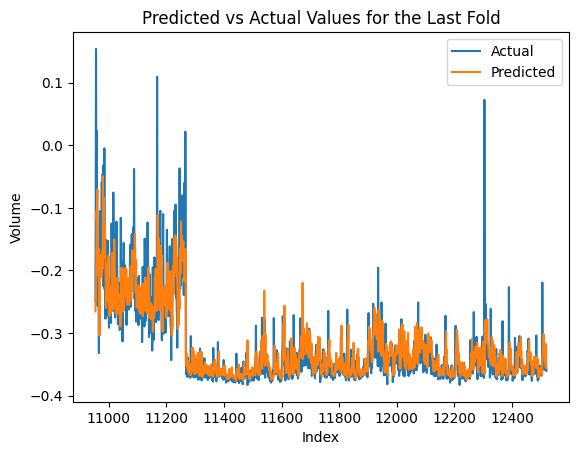

Test RMSE with default parameters: 0.06928433950099955


In [ ]:
# Evaluate the base model on the test set
test_rmse_default, y_test_rf_default, indices_default = time_series_valid_test(X_scaled, y_scaled, 3, 'test', default=True)
print("Test RMSE with default parameters:", test_rmse_default)

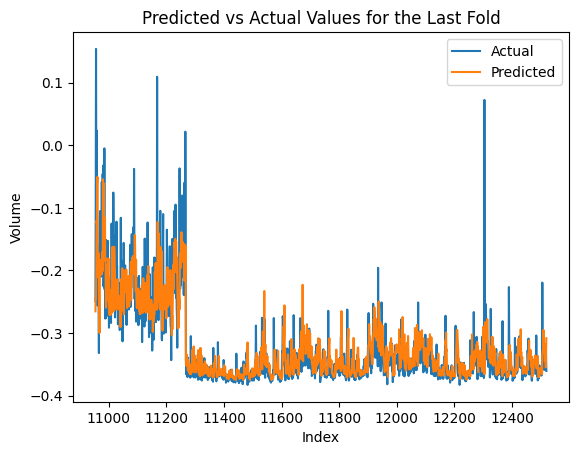

Test RMSE with tuned parameters: 0.06901415112646213


In [ ]:
# Evaluate the best model on the test set
test_rmse_tuned, y_test_rf_tuned, indices_tuned = time_series_valid_test(X_scaled, y_scaled, 3, 'test', optimal_par=best_params)
print("Test RMSE with tuned parameters:", test_rmse_tuned)

Comparing the test RMSE values and the plots, we find that both models perform relatively close on new and unseen data, with a slight advantage present in the best configuration model. While the improvement is not significant, it suggests that the random forest model can benefit from careful tuning of its parameters. As seen in the plots, the model still has some difficulty in accurately predicting extreme spikes in volume but performs slightly better in capturing the general pattern of volume fluctuations.

### **Feature Importances**

Feature importance is an important concept in machine learning that provides insight into the underlying relationships in the data by highlighting which features have the greatest impact on predictions, and provides a way to interpret the model. By focusing on the most important features, we are able to further investigate the problem of simplifying the model, reducing overfitting, and improving generalization.

In [ ]:
# Define feature names
feature_names = [f'Volume_t-{i}' for i in range(1, 6)] + \
                [f'Daily_Return_t-{i}' for i in range(1, 6)]

# Initialize importances array
importances = np.zeros(len(feature_names))

# Compute feature importances over 3 folds
for i in range(3):
    train_index = indices_tuned[i][0]
    X_train = X_scaled.iloc[train_index]
    y_train = y_scaled.iloc[train_index]

    # Train the model on the sampled data
    model = RandomForestRegressor(random_state=42, n_jobs=-1,
                                  ccp_alpha=best_params['ccp_alpha'],
                                  n_estimators=best_params['n_estimators'],
                                  max_depth=best_params['max_depth'])
    model.fit(X_train, y_train)

    # Accumulate feature importances
    importances += model.feature_importances_

# Average the importances
importances /= 3

# Displaying feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

            Feature  Importance
0        Volume_t-1    0.556301
1        Volume_t-2    0.102950
2        Volume_t-3    0.067814
3        Volume_t-4    0.058400
4        Volume_t-5    0.052688
9  Daily_Return_t-5    0.036618
6  Daily_Return_t-2    0.032905
8  Daily_Return_t-4    0.032451
7  Daily_Return_t-3    0.030272
5  Daily_Return_t-1    0.029600


The high importance of $volume_{t-1}$ suggests that the volume on the previous day is a strong predictor of the following day's volume. This could be due to the persistence of trading patterns, where high volume on one day often leads to high volume on the next. In addition, the declining importance of `volume` features as we go further back in time ($volume_{t-2}$ to $volume_{t-5}$) reflects that more recent trading volumes have a greater influence on future volumes compared to older volumes.

The daily return features, while less impactful than the volume features, still play a significant role. The relatively even distribution of importance among the daily return features suggests that returns from the past five days collectively contribute to the model's predictions, with no single day being overwhelmingly influential.

### **Compared with Naive Forecast Model**

To verify that our model is valid, it is useful to compare its performance with a very simple method of prediction. From the feature importance section, we learn that the most recent trading volume has a significant impact on predicting future volume. Thus, we compute the RMSE of a model that simply predicts the 1-step ahead value of `Volume` ($volume_{t+1}$) as the previous day's value ($volume_{t-1}$) on the test set, and compares this to the random forest model with best configuration.

In [ ]:
# Calculate Naive Forecast RMSE
def naive_forecast_rmse(X, y, indices):
    naive_rmses = []

    for _, _, test_index in indices:
        # Retrieve the test data
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        # Naive forecast where the prediction for Volume_{t+1} is Volume_{t-1}
        y_pred_naive = X_test.iloc[:, 0]
        rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
        naive_rmses.append(rmse_naive)

    # Calculate the mean RMSE across all folds
    mean_naive_rmse = np.mean(naive_rmses)
    return mean_naive_rmse

In [ ]:
# Calculate Naive Forecast RMSE on the same test indices
rmse_naive = naive_forecast_rmse(X_scaled, y_scaled, indices_tuned)
print("Naive Forecast RMSE:", rmse_naive)

# Compare Naive Forecast with Random Forest
if rmse_naive < test_rmse_tuned:
    print("Naive model performs better than Random Forest.")
else:
    print("Random Forest model outperforms the naive model.")

Naive Forecast RMSE: 0.07046687353829491
Random Forest model outperforms the naive model.


The results of the evaluation indicate that the random forest models (especially the tuned models) were able to predict the following day's trading volume more accurately than the simple prediction methods. The lower RMSE values of the random forest models reflect their ability to capture underlying patterns and trends in the data, which naive forecast models are unable to do. This demonstrates the added value of using complex machine learning techniques in time series forecasting over using simple heuristics.

## **Conclusion**

In this project, we aim to develop and evaluate predictive models for forecasting the next day's trading volume of selected stocks using random forest regressors. The process involves several key steps including data preprocessing, feature engineering, model training, hyperparameter tuning, and performance evaluation. By preprocessing the data, we utilize historical trading volume and daily return data to create lagged variables and use them as predictive features to capture the time dependence inherent in the dataset.

We employed a 3-fold time series cross-validation approach to evaluate the model, which maintains the temporal order of the data and provides a robust evaluation framework. Hyperparameter tuning was performed to optimize the model performance, focusing on parameters such as the number of estimators (`n_estimators`), maximum tree depth (`max_depth`), and cost-complexity pruning parameter (`ccp_alpha`). It is observed that the performance of the base model with default settings is moderate, while the performance of the tuned model is sensitive to the hyperparameter values. Larger values of `ccp_alpha` (like 0.001) result in larger RMSE for the model, which performs even worse than the base model and would not be significantly improved by the tuning of the other two parameters. In addition, not limiting `max_depth` usually leads to optimized RMSE values.

Overall, smaller values of `ccp_alpha` and larger values of `n_estimators` tend to produce better performance in this dataset. The best configuration occurs with `ccp_alpha` set to 1e-07, `max_depth` set to None, and `n_estimators` set to 400. This indicates that deeper trees without pruning (given the low `ccp_alpha` value) and a moderate number of trees (400 estimators) provided the best results.

By using the base model and the best-configured model on the test set, we further evaluated their performance and generalization ability on unseen data. The performance of the two models on new data is relatively close, with both obtaining low RMSE values, while the best-configured model is slightly outperformed. However, as can be seen in the plots, the random forest model still has some difficulty in accurately predicting extreme peaks in volume and performs slightly better in capturing the general pattern of volume fluctuations.

Beyond the investigation of model performance, we also study feature importance. We find that most recent trading volume, especially the previous day's volume, has a significant impact on forecasts, which is consistent with the intuition that trading activity has short-term momentum. Although daily returns are less influential than trading volume, they still provide valuable predictive information, suggesting that price movements contribute to volume prediction.

Since the previous day's trading volume has an significant impact on the prediction, we utilize this feature to build a simple forecasting model, which considers the prediction of the next day as the previous day's trading volume. To verify our model is valid, we compare the performance of the random forest model with the simple forecasting model. The tuned random forest model with a tested RMSE of 0.0690 outperforms the simple model with a RMSE of 0.0705, demonstrating its ability to capture complex patterns in historical data. While the improvement in performance from hyperparameters is not significant, the tuning proves to be beneficial and outperforms the simple forecasting model in terms of accuracy.

Conclusively, our work emphasizes the importance of feature engineering and model tuning in developing effective financial time series forecasting models, and validates the effectiveness of the random forest model in predicting future trading volume, providing a valuable reference for identifying potential buy or sell signals. The insights gained from the feature importance analysis can not only improve the interpretability of the model, but also guide future feature engineering efforts that can help construct more complex models, thus further improving forecasting performance. Future research could explore other features such as moving averages, volatility indices, and external factors such as market sentiment, or consider more sophisticated models such as neural networks, deep learning architectures, and integrated approaches to capture dynamic patterns in the data.

## **Reference**

[1] Vijh, M., Chandola, D., et al. *Stock Closing Price Prediction using Machine Learning Techniques*, Procedia Computer Science, Vol. 167, 2020, pp. 599-606.

[2] G'eron, A. *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 3rd edition, O’Reilly, 2022.